In [2]:
import sys

sys.path.append('../model_generator')
sys.path.append('../patient_sample_generator')
sys.path.append('../ebm')
sys.path.append('../old_model_generator')
sys.path.append('../ebm')

from model_generator.model_factory import ModelFactory
#from patient_sample_generator.sample_generator import SampleGenerator
from ebm.ebm_transformer import EBMModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, spearmanr, kendalltau


# Get the absolute path of the current notebook


#from ..model_generator.model_factory import ModelFactory
from old_model_generator.canonical_generator import CanonicalGenerator
from old_model_generator.sample_generator import SampleGenerator

from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities

In [2]:
def run_ebm(X, y, prior = None, random_state = 1):
    
    log_p_e, log_p_not_e = log_distributions(X, y, point_proba=False)
    
    rng = np.random.RandomState(random_state)
    ideal_order = np.arange(X.shape[1])
    # ditching np.shuffle due to lack of ability to assign randomized starting-order to variable
    starting_order = rng.choice(ideal_order, len(ideal_order), replace=False)
    starting_order_copy = starting_order.copy()
     
    order, loglike, update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                                n_iter=10_000, order = starting_order,
                                                prior=prior,
                                                random_state=random_state)
    
    greedy_loglike = loglike
    greedy_order = order.copy()
    orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e,
                                                 order=order, n_iter=500_000,
                                                 prior = prior,
                                                 random_state=random_state)
    
    if len(orders) != 0:
        best_order_idx = np.argmax(loglike)
        best_order = orders[best_order_idx]
        best_order = best_order.copy()
    if len(orders) == 0:
        print("Warning: MCMC did not accept new orders, returning greedy ascent result.")
        best_order = order
    
    ## statistical calculations
    
    num_iters = len(orders)
    
    starting_spearmanr, _ = spearmanr(ideal_order, starting_order_copy)
    greedy_spearmanr, _ = spearmanr(ideal_order, greedy_order)
    best_spearmanr, _ = spearmanr(ideal_order, best_order)

    starting_kendalltau, _ = kendalltau(ideal_order, starting_order_copy)
    greedy_kendalltau, _ = kendalltau(ideal_order, greedy_order)
    best_kendalltau, _ = kendalltau(ideal_order, best_order)
    
    ## results dict
    
    results = {
        'starting_order': starting_order_copy,
        'greedy_order': greedy_order,
        'best_order': best_order,
        'starting_spearmanr': starting_spearmanr,
        'greedy_spearmanr': greedy_spearmanr,
        'best_spearmanr': best_spearmanr,        
        'starting_kendalltau': starting_kendalltau,
        'greedy_kendalltau': greedy_kendalltau,
        'best_kendalltau': best_kendalltau,
        'num_iters': num_iters
    }
    
    return results

def run_multiple_ebm(X, y, prior = None, n_trials = 10, csv_filename = 'name.csv'):
    results_list = []

    for trial in range(n_trials):
        result = run_ebm(X, y, prior, random_state=trial)
        results_list.append({
            'run': trial,
            'starting_order': result['starting_order'].tolist(),
            'greedy_order': result['greedy_order'].tolist(),
            'best_order': result['best_order'].tolist(),
            'starting_spearmanr': result['starting_spearmanr'],
            'greedy_spearmanr': result['greedy_spearmanr'],
            'best_spearmanr': result['best_spearmanr'],
            'starting_kendalltau': result['starting_kendalltau'],
            'greedy_kendalltau': result['greedy_kendalltau'],
            'best_kendalltau': result['best_kendalltau'],
            'num_iters': result['num_iters']
        })
    
    df = pd.DataFrame(results_list)
    df.to_csv(csv_filename, index=False)
    return df

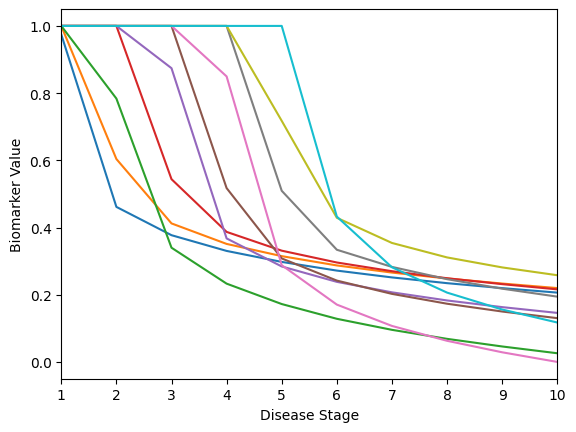

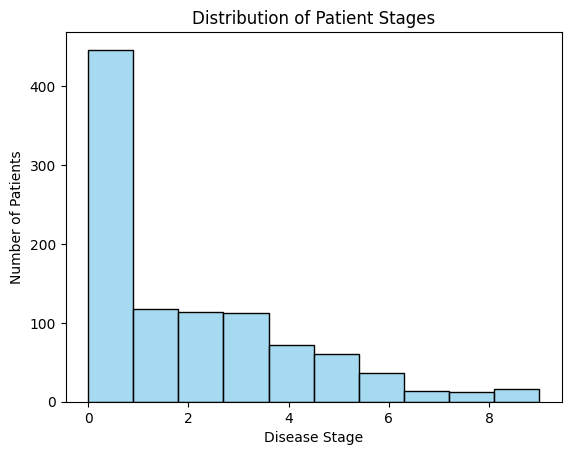

In [4]:
params = {
    'n_stages': 10,
    'l1_mean': 5.0,
    'l2_mean': 5.0,
    'gamma_mean': 0.9,
    'eta_mean': 0.3,
    'k_ij_value': 0.6,
    'random_state': 10,
    'start_time': 0,
    'end_time': 150,
    'steps': 200,
    'staging': 'whole',
    'matrix_type': 'Tridiagonal',
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('acp', **params)
model.fit()
prior = model.get_connectivity_matrix()
model.plot()
stage_values = model.transform(X=None) 

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':1, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

sample.plot_stage_histogram()

In [ ]:
X = sample.get_X()
y = sample.get_y()

#run_multiple_ebm(X=X, y=y, csv_filename="transition_results.csv");

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"ACP_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"ACP_results_prior_n{sample.n_patients}.csv");

In [4]:
params = {
    'n_stages': 10,
    'l1_mean': 5.0,
    'l2_mean': 5.0,
    'gamma_mean': 0.9,
    'eta_mean': 0.3,
    'k_ij_value': 0.6,
    'random_state': 10,
    'start_time': 0,
    'end_time': 150,
    'steps': 200,
    'staging': 'whole',
    'matrix_type': 'Tridiagonal',
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('acp', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None) 

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=500,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"ACP_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"ACP_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [01:37<00:00, 5119.38it/s]


In [5]:
params = {
    'n_stages': 10,
    'l1_mean': 5.0,
    'l2_mean': 5.0,
    'gamma_mean': 0.9,
    'eta_mean': 0.3,
    'k_ij_value': 0.6,
    'random_state': 10,
    'start_time': 0,
    'end_time': 150,
    'steps': 200,
    'staging': 'whole',
    'matrix_type': 'Tridiagonal',
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('acp', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None) 

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=200,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"ACP_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"ACP_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [00:52<00:00, 9596.56it/s] 


In [6]:
params = {
    'n_stages': 10,
    'l1_mean': 5.0,
    'l2_mean': 5.0,
    'gamma_mean': 0.9,
    'eta_mean': 0.3,
    'k_ij_value': 0.6,
    'random_state': 10,
    'start_time': 0,
    'end_time': 150,
    'steps': 200,
    'staging': 'whole',
    'matrix_type': 'Tridiagonal',
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('acp', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None) 

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=100,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"ACP_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"ACP_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [00:35<00:00, 14234.33it/s]
